In [ ]:
# default_exp features

In [1]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
! pip install opencv-python ffmpeg pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.4-py2.py3-none-any.whl size=13811 sha256=a24c68ec6ec933495efe66c45dada7161cc09e9dfa80da5aa87512f171ab082d
  Stored in directory: /root/.cache/pip/wheels/df/da/38/ab64f024f69d2c013ae96b75003fd874460698362ccdc054e1
Successfully built pytesseract


In [8]:
! apt-get install git wget vim libsm6 libxext6 libxrender-dev libx264-dev tesseract-ocr libtesseract-dev -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.17.1-1ubuntu0.7).
The following additional packages will be installed:
  fontconfig fontconfig-config fonts-dejavu-core libbsd0 libcairo2 libdatrie1
  libfontconfig1 libgif7 libgpm2 libgraphite2-3 libharfbuzz0b libice6 libicu60
  libjbig0 liblept5 libleptonica-dev libopenjp2-7 libpango-1.0-0
  libpangocairo-1.0-0 libpangoft2-1.0-0 libpixman-1-0 libpthread-stubs0-dev
  libtesseract4 libthai-data libthai0 libtiff5 libwebp6 libx11-6 libx11-data
  libx11-dev libx11-doc libx264-152 libxau-dev libxau6 libxcb-render0
  libxcb-shm0 libxcb1 libxcb1-dev libxdmcp-dev libxdmcp6 libxrender1
  tesseract-ocr-eng tesseract-ocr-osd ucf vim-common vim-runtime x11-common
  x11proto-core-dev x11proto-dev xorg-sgml-doctools xtrans-dev xxd
Suggested packages:
  gpm libxcb-doc ctags vim-doc vim-scripts
The following NEW packages will be installed:
  fontconfig fontconfig-conf

Selecting previously unselected package libxau6:amd64.
(Reading database ... 17013 files and directories currently installed.)
Preparing to unpack .../00-libxau6_1%3a1.0.8-1_amd64.deb ...
Unpacking libxau6:amd64 (1:1.0.8-1) ...
Selecting previously unselected package libbsd0:amd64.
Preparing to unpack .../01-libbsd0_0.8.7-1ubuntu0.1_amd64.deb ...
Unpacking libbsd0:amd64 (0.8.7-1ubuntu0.1) ...
Selecting previously unselected package libxdmcp6:amd64.
Preparing to unpack .../02-libxdmcp6_1%3a1.1.2-3_amd64.deb ...
Unpacking libxdmcp6:amd64 (1:1.1.2-3) ...
Selecting previously unselected package libxcb1:amd64.
Preparing to unpack .../03-libxcb1_1.13-2~ubuntu18.04_amd64.deb ...
Unpacking libxcb1:amd64 (1.13-2~ubuntu18.04) ...
Selecting previously unselected package libx11-data.
Preparing to unpack .../04-libx11-data_2%3a1.6.4-3ubuntu0.2_all.deb ...
Unpacking libx11-data (2:1.6.4-3ubuntu0.2) ...
Selecting previously unselected package libx11-6:amd64.
Preparing to unpack .../05-libx11-6_2%3a1.

Selecting previously unselected package xtrans-dev.
Preparing to unpack .../48-xtrans-dev_1.3.5-1_all.deb ...
Unpacking xtrans-dev (1.3.5-1) ...
Selecting previously unselected package libxcb1-dev:amd64.
Preparing to unpack .../49-libxcb1-dev_1.13-2~ubuntu18.04_amd64.deb ...
Unpacking libxcb1-dev:amd64 (1.13-2~ubuntu18.04) ...
Selecting previously unselected package libx11-dev:amd64.
Preparing to unpack .../50-libx11-dev_2%3a1.6.4-3ubuntu0.2_amd64.deb ...
Unpacking libx11-dev:amd64 (2:1.6.4-3ubuntu0.2) ...
Selecting previously unselected package libx11-doc.
Preparing to unpack .../51-libx11-doc_2%3a1.6.4-3ubuntu0.2_all.deb ...
Unpacking libx11-doc (2:1.6.4-3ubuntu0.2) ...
Selecting previously unselected package libx264-152:amd64.
Preparing to unpack .../52-libx264-152_2%3a0.152.2854+gite9a5903-2_amd64.deb ...
Unpacking libx264-152:amd64 (2:0.152.2854+gite9a5903-2) ...
Selecting previously unselected package libx264-dev:amd64.
Preparing to unpack .../53-libx264-dev_2%3a0.152.2854+gite9a

Setting up libharfbuzz0b:amd64 (1.7.2-1ubuntu1) ...
Setting up libxau-dev:amd64 (1:1.0.8-1) ...
Setting up libthai0:amd64 (0.1.27-2) ...
Setting up liblept5 (1.75.3-3) ...
Setting up libxdmcp-dev:amd64 (1:1.1.2-3) ...
Setting up libice6:amd64 (2:1.0.9-2) ...
Setting up libxcb1:amd64 (1.13-2~ubuntu18.04) ...
Setting up libfontconfig1:amd64 (2.12.6-0ubuntu2) ...
Setting up libsm6:amd64 (2:1.2.2-1) ...
Setting up libxcb-render0:amd64 (1.13-2~ubuntu18.04) ...
Setting up libleptonica-dev (1.75.3-3) ...
Setting up libx11-6:amd64 (2:1.6.4-3ubuntu0.2) ...
Setting up libtesseract4 (4.00~git2288-10f4998a-2) ...
Setting up libtesseract-dev (4.00~git2288-10f4998a-2) ...
Setting up libxcb-shm0:amd64 (1.13-2~ubuntu18.04) ...
Setting up libxrender1:amd64 (1:0.9.10-1) ...
Setting up libxcb1-dev:amd64 (1.13-2~ubuntu18.04) ...
Setting up libx11-dev:amd64 (2:1.6.4-3ubuntu0.2) ...
Setting up fontconfig (2.12.6-0ubuntu2) ...
Regenerating fonts cache... done.
Setting up libxext6:amd64 (2:1.3.3-1) ...
Settin

# Features


> This module contains all the necessary functions for extracting and organizing features from videos.

In [35]:
#export
import cv2
# import ffmpeg

import torch

import numpy as np

from abc import ABC, abstractmethod

# from fastprogress.fastprogress import progress_bar

# tango
from tango.prep import *

# from tango.cnn import *
from tango.model import *

from pathlib import Path

from PIL import Image

# from matplotlib import pyplot as plt

# from nbdev.showdoc import *

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
torch.__version__

'1.7.0.dev20200702'

In [4]:
path = Path("/tf/data/datasets/videos")
video_paths = sorted(path.glob("**/video.mp4")); video_paths[:6]

[PosixPath('/tf/data/datasets/videos/art_and_design/ibis_paint/scenario1/video.mp4'),
 PosixPath('/tf/data/datasets/videos/art_and_design/ibis_paint/scenario2/video.mp4'),
 PosixPath('/tf/data/datasets/videos/art_and_design/pixel_art_paint/scenario1/video.mp4'),
 PosixPath('/tf/data/datasets/videos/art_and_design/pixel_art_paint/scenario2/video.mp4'),
 PosixPath('/tf/data/datasets/videos/auto_and_vehicles/car_part/scenario1/video.mp4'),
 PosixPath('/tf/data/datasets/videos/auto_and_vehicles/car_part/scenario2/video.mp4')]

In [5]:
rico_path = Path('/tf/data/combined/data')
img_paths = sorted(rico_path.glob('*.jpg'))
len(img_paths), img_paths[:5]

(66261,
 [PosixPath('/tf/data/combined/data/0.jpg'),
  PosixPath('/tf/data/combined/data/1.jpg'),
  PosixPath('/tf/data/combined/data/10.jpg'),
  PosixPath('/tf/data/combined/data/100.jpg'),
  PosixPath('/tf/data/combined/data/1000.jpg')])

In [22]:
from random import sample

n = 10 # 10_000
# sampled_imgs = [np.array(Image.open(img)) for img in sample(img_paths, n)]
sampled_imgs = [Image.open(img) for img in sample(img_paths, n)]
len(sampled_imgs)

10

In [23]:
#export
class Extractor(ABC):

    def __init__(self, extractor):
        self.extractor = extractor
        super().__init__()
    
    @abstractmethod
    def extract(self, img):
        pass

In [24]:
#export
class SIFTExtractor(Extractor):
    
    '''Exposed SIFTExtractor class used for retrieving features.'''

    def extract(self, img):
        '''Given an image, extract features using SIFT. Returns the feature vector.'''
#         print(type(img))
        img = np.array(img)
        _, features = self.extractor.detectAndCompute(img, None)
#         features = features.ravel()
#         features = np.expand_dims(features, axis=0)
        return features
    
class CNNExtractor(Extractor):
   
    '''Exposed CNNExtractor class used for retrieving features.'''

    def extract(self, img):
        '''Given an image, extract features from the layers of a CNN. Returns the feature vector.'''
        
        return self.extractor.getFeatures(img)

In [28]:
# export
from torchvision import transforms

def imagenet_normalize_transform():
    return transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def get_transforms(size=224):
    return transforms.Compose([
        transforms.Resize(size=(size, size)),
        transforms.ToTensor(),
        imagenet_normalize_transform()
    ])

class SimCLRExtractor(Extractor):
   
    '''Exposed CNNExtractor class used for retrieving features.'''
    def __init__(self, extractor):
        super().__init__(extractor)
        self.transforms = get_transforms()

    def extract(self, img):
        '''Given an image, extract features from the layers of a CNN. Returns the feature vector.'''
        img = self.transforms(img).float()
        img = img.unsqueeze(0)
        return self.extractor(img).detach().numpy()

In [31]:
model = SimCLRModel.load_from_checkpoint(checkpoint_path='/tf/data/models/simclr/checkpointepoch=98.ckpt').eval()
simclr_extractor = SimCLRExtractor(model)

In [52]:
features_0 = simclr_extractor.extract(sampled_imgs[7]).detach().numpy()
features_1 = simclr_extractor.extract(sampled_imgs[9]).detach().numpy()

In [17]:
imgs = get_rand_imgs(video_paths[0], 30_000, n = 100)

In [18]:
#Three different extraction techniques
# learn, linear_output_layer = trainPetsModel()
# extractor = CNNExtractor(cnn.createExtractor(learn, linear_output_layer, 'resnet50', True))
extractor = CNNExtractor(createExtractor(None, None, 'resnet50', False))
# extractor = CNNExtractor(cnn.createLayeredExtractor())

In [24]:
sampled_imgs[0]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
      

In [26]:
#Using the extractor to extract the feature vector
features = extractor.extract(sampled_imgs[0])

In [28]:
#export
def gen_vcodebook(imgs, extractor, vwords = 10_000):
    """
        Constructs a visual codebook based on the given images.
        You can change vwords to increase the vocabulary of the codebook.
    """
    features_list = []
    for img in imgs:
        features = extractor.extract(img)
        features_list.extend(features)
        
    features_list = np.asarray(features_list)
    print(features_list.shape)
    codebook = KMeans(n_clusters = vwords)
    codebook.fit(features_list)
    
    return codebook

In [ ]:
vwords = 1_000
codebook = gen_vcodebook(sampled_imgs, extractor, vwords)

In [ ]:
fname = f'/tf/data/models/cookbook_{len(sampled_imgs)}n_{vwords}vw.model'
pickle.dump(codebook, open(fname, 'wb'))

# load the model from disk
# codebook = pickle.load(open(fname, 'rb'))

<BarContainer object of 20 artists>

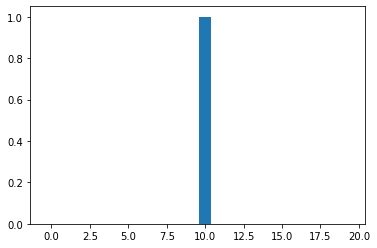

In [ ]:
#hide
labels = codebook.predict(features)
hist = np.histogram(labels, bins = range(vwords + 1))
plt.bar(range(vwords), hist[0])

In [ ]:
# #export
# def get_df(imgs, extractor, codebook, vwords):
#     """Generates the document frequency for the visual words"""
#     arr = []
#     for img in imgs:
#         features = extractor.extract(img)
#         vw = codebook.predict(features)
#         arr.extend(vw)
#     arr = np.asarray(arr)
    
#     return np.histogram(arr, bins = range(vwords))

In [ ]:
#export
def get_df(imgs, extractor, codebook, vwords):
    """Generates the document frequency for the visual words"""
    arr = []
    for img in imgs:
        features = extractor.extract(img)
        vw = codebook.predict(features)
        arr.extend(vw)
    arr = np.asarray(arr)
    
    return np.histogram(arr, bins = range(vwords + 1))

In [ ]:
df = get_df(imgs, extractor, codebook, vwords)

In [ ]:
#hide
df

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 100,   0,   0,   0,   0,   0,   0,   0,   0,   0])

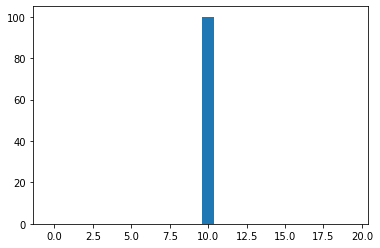

In [ ]:
#hide
plt.bar(range(vwords), df)
plt.show()

In [ ]:
#export
def get_bovw(vid_path, extractor, codebook, vwords, n = None):
    """Generates the bag of visual words (bovw) for an entire video."""
    vid = cv2.VideoCapture(str(vid_path))
    if n is None: n = vid.get(cv2.CAP_PROP_FRAME_COUNT)
    
    # checks whether frames were extracted 
    success = 1
    bovw = np.array([])
    for i in progress_bar(range(n)):
        # vid object calls read 
        # function extract frames 
        success, img = vid.read() 
        if success:
            features = extractor.extract(img)
            vw = codebook.predict(features)
            bovw = np.concatenate((bovw, vw))
    
    hist = np.histogram(bovw, bins = range(vwords + 1))[0]
    return hist, bovw

In [ ]:
# #export
# def new_get_bovw(vid, extractor, codebook, vwords, fps = 30, frames_to_keep = 1):
#     bovw = []
#     for i in range(0, len(vid), int(fps / frames_to_keep)):
#         img = vid[i]
#         if not img: continue
#         features = extractor.extract(img)
#         vw = codebook.predict(features)
#         bovw.extend(vw)
    
#     bovw = np.array(bovw)
#     bovw = np.histogram(bovw, bins = range(vwords + 1))[0]
#     return bovw
# #         bovw = np.concatenate((bovw, vw))

In [ ]:
#export
def extract_features(vid, extractor, fps = 30, frames_to_keep = 1):
    extracted_features = []
    for i in range(0, len(vid), int(fps / frames_to_keep)):
        img = vid[i]
        if not img: continue
        extracted_features.append(extractor.extract(img))
    
    return extracted_features

In [84]:
list(range(0, 30, 4))

[0, 4, 8, 12, 16, 20, 24, 28]

In [88]:
[x * 4 for x in range(0, 7)]

[0, 4, 8, 12, 16, 20, 24]

In [86]:
30 / 4

7.5

In [ ]:
#export
def new_get_bovw(features, codebook, vwords):
    bovw = []
    for f in features:
        vw = codebook.predict(f)
        bovw.extend(vw)
    
    bovw = np.array(bovw)
    bovw = np.histogram(bovw, bins = range(vwords + 1))[0]
    return bovw

In [ ]:
vid = Video(video_paths[3])
features = extract_features(vid, extractor, fps = 30, frames_to_keep = 1)
bovw = new_get_bovw(features, codebook, vwords, frames_to_keep = 2)

In [ ]:
len(bovw)

26

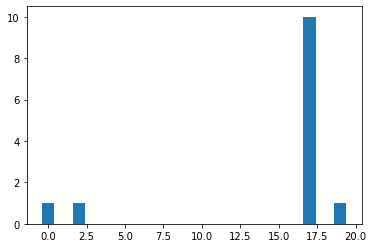

array([ 1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  1])

In [ ]:
#hide
plt.bar(range(vwords), hist)
plt.show()
hist

In [ ]:
#export
def calc_tf_idf(tfs, dfs):
    tf_idf = np.array([])
    for tf, df in zip(tfs, dfs):
        tf = tf / np.sum(tfs)
        idf = np.log(len(tfs) / (df + 1))
        tf_idf = np.append(tf_idf, tf * idf)
    
    return tf_idf

In [ ]:
tf_idf_pix2 = calc_tf_idf(hist, df)

In [ ]:
#hide
hist2, bovw2 = get_bovw(video_paths[2], extractor, codebook)
tf_idf_pix1 = calc_tf_idf(hist2, df)

In [ ]:
#hide
hist3, bovw3 = get_bovw(video_paths[4], extractor, codebook)
tf_idf_car1 = calc_tf_idf(hist3, df)

In [ ]:
#hide
hist4, bow4 = get_bovw(video_paths[5], extractor, codebook)
tf_idf_car2 = calc_tf_idf(hist4, df)

In [ ]:
#hide
np.dot(tf_idf_pix1, tf_idf_pix2) / (np.linalg.norm(tf_idf_pix1) * np.linalg.norm(tf_idf_pix2))

In [ ]:
#hide
np.dot(tf_idf_car1, tf_idf_car2) / (np.linalg.norm(tf_idf_car1) * np.linalg.norm(tf_idf_car2))

In [ ]:
#hide
np.dot(tf_idf_pix1, tf_idf_car1) / (np.linalg.norm(tf_idf_pix1) * np.linalg.norm(tf_idf_car1))

In [ ]:
#hide
np.dot(tf_idf_pix2, tf_idf_car2) / (np.linalg.norm(tf_idf_pix2) * np.linalg.norm(tf_idf_car2))

In [ ]:
#hide
np.dot(tf_idf_pix1, tf_idf_pix1) / (np.linalg.norm(tf_idf_pix1) * np.linalg.norm(tf_idf_pix1))

In [ ]:
#hide
np.dot(tf_idf_car1, tf_idf_car1) / (np.linalg.norm(tf_idf_car1) * np.linalg.norm(tf_idf_car1))

In [ ]:
#hide
%%HTML
<video width="420" height="315" controls autoplay>
    <source src="../../data/datasets/videos/art_and_design/pixel_art_paint/scenario2/video.mp4" type="video/mp4"/>
</video>

In [ ]:
#hide
%%HTML
<video width="420" height="315" controls autoplay>
    <source src="../../data/datasets/videos/art_and_design/pixel_art_paint/scenario1/video.mp4" type="video/mp4"/>
</video>

In [ ]:
#hide
%%HTML
<video width="420" height="315" controls autoplay>
    <source src="../../data/datasets/videos/auto_and_vehicles/car_part/scenario1/video.mp4" type="video/mp4"/>
</video>

In [83]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_prep.ipynb.
Converted 01_features.ipynb.
Converted 02_eval.ipynb.
Converted 03_cnn.ipynb.
This cell doesn't have an export destination and was ignored:
 
Converted 04.0_experiments.ipynb.
Converted 04.1_experiments.codebooks.ipynb.
Converted 05_model.ipynb.
Converted 06_approach.ipynb.
Converted SimCLR.old.ipynb.
Converted [Scratch 1] Tango SimCLR.ipynb.
Converted [Scratch 2] Tango SimCLR.ipynb.
Converted index.ipynb.
Converted lesson1-pets.ipynb.
